In [1]:
import numpy as np
import torch
import h5py
import os

from dataset import Spectrogram, SpectrogramParamDataset
from embedding import Encoder, EncoderWrapper, VICRegLoss

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

## Data

In [2]:
num_files = 1

data_dir = '/Users/shreyaggarwal/Desktop/Project8581/data/train/'

## Data Loader

In [3]:

torch_dataset = SpectrogramParamDataset(data_dir, 1)

train_set_size = 0.8
val_set_size = 0.1
test_set_size = 0.1

train_data, val_data, test_data = torch.utils.data.random_split(
    torch_dataset, [train_set_size, val_set_size, test_set_size])

TRAIN_BATCH_SIZE = 30
VAL_BATCH_SIZE = 30

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

## Model

## Training

In [4]:
len(train_data_loader)

6

In [5]:
import tqdm

num_epochs = 10
embedding_dim = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizer
encoder1 = Encoder(embedding_dim)
encoder2 = Encoder(embedding_dim)

criterion = VICRegLoss()
optimizer = optim.Adam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=1e-3)

train_losses = []
val_losses = []


i = 0
t = 10

len_train = len(train_data_loader)
wrapper = EncoderWrapper(encoder1, encoder2)

for epoch in range(num_epochs):

    print(epoch)
    encoder1.train()
    encoder2.train()
    total_train_loss = 0
    total_val_loss = 0

    # --- Training ---
    for param_data, batch_data in train_data_loader:
        batch_data = batch_data.to(device)
        param_data = param_data.to(device)  # optional: not used in VICReg

        emb1, emb2 = wrapper(batch_data)

        # VICReg loss across time shifts
        loss1 = 0
        loss2 = 0
        for i in range(t-1):
            loss1 += criterion(emb1[:, i, :], emb1[:, i+1, :])[0]
            loss2 += criterion(emb2[:, i, :], emb2[:, i+1, :])[0]

        print(loss1, loss2)
        loss = (loss1 + loss2) / (2 * (t-1))
        total_train_loss += loss.item()
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # --- Validation ---
    encoder1.eval()
    encoder2.eval()
    
    with torch.no_grad():
        for param_data, batch_data in val_data_loader:
            batch_data = batch_data.to(device)
            param_data = param_data.to(device)  # optional: not used in VICReg

            emb1, emb2 = wrapper(batch_data)

            loss1 = 0
            loss2 = 0
            for i in range(t-1):
                loss1 += criterion(emb1[:, i, :], emb1[:, i+1, :])[0]
                loss2 += criterion(emb2[:, i, :], emb2[:, i+1, :])[0]

            loss = (loss1 + loss2) / (2 * (t-1))
            total_val_loss += loss.item()


    avg_train_loss = total_train_loss / len(train_data_loader)
    avg_val_loss = total_val_loss / len(val_data_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

0
tensor(198.6942, grad_fn=<AddBackward0>) tensor(291.6017, grad_fn=<AddBackward0>)
tensor(6102.7188, grad_fn=<AddBackward0>) tensor(191.9164, grad_fn=<AddBackward0>)
tensor(191.3674, grad_fn=<AddBackward0>) tensor(190.2463, grad_fn=<AddBackward0>)
tensor(193.5205, grad_fn=<AddBackward0>) tensor(1211.7418, grad_fn=<AddBackward0>)
tensor(197.7734, grad_fn=<AddBackward0>) tensor(260590.8438, grad_fn=<AddBackward0>)
tensor(193.9745, grad_fn=<AddBackward0>) tensor(198.4010, grad_fn=<AddBackward0>)
Epoch 1 | Train Loss: 2497.7110 | Val Loss: 36.3561
1
tensor(225.7107, grad_fn=<AddBackward0>) tensor(195.7760, grad_fn=<AddBackward0>)
tensor(200.1328, grad_fn=<AddBackward0>) tensor(208.6025, grad_fn=<AddBackward0>)
tensor(203.2987, grad_fn=<AddBackward0>) tensor(210.5680, grad_fn=<AddBackward0>)
tensor(206.8038, grad_fn=<AddBackward0>) tensor(212.9045, grad_fn=<AddBackward0>)
tensor(204.4033, grad_fn=<AddBackward0>) tensor(1491.5585, grad_fn=<AddBackward0>)
tensor(205.2361, grad_fn=<AddBackwar

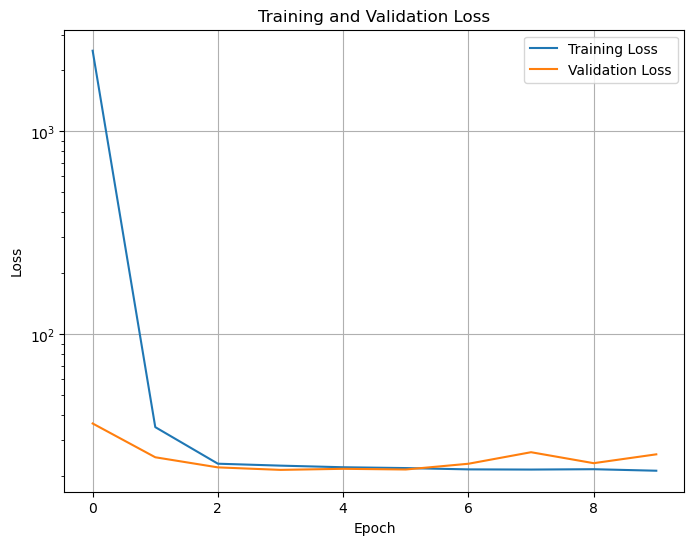

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('sine_wave.png')
plt.show()

# Save the final pretrained encoders
torch.save({
    'encoder1_state_dict': encoder1.state_dict(),
    'encoder2_state_dict': encoder2.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, f='emb.pth')


In [10]:
train_losses[-1]

21.823498090108234

In [7]:
batch_data.shape

torch.Size([21, 10, 2, 80, 205])

In [9]:
emb1.shape

torch.Size([21, 10, 128])